<a href="https://colab.research.google.com/github/ps-nithin/pyrebel/blob/main/pyvision_edge_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Demo of edge detection using data abstraction**

In [ ]:
# Setup the input files

from google.colab import files
uploaded = files.upload()

In [ ]:
import math
from math import sqrt
import time
from numba import cuda
import numpy as np
import cmath
from PIL import Image
from numba import float32,int32
import numba

In [ ]:
# Choose the file

file_name="wildlife.jpg"
img_file=Image.open(file_name)
img_file

In [ ]:
# Function definitions

@cuda.jit
def clone_image(img_array,img_clone,color):
    r,c=cuda.grid(2)
    if r<img_array.shape[0] and c<img_array.shape[1]:
        if img_array[r][c]==color:
            img_clone[r][c]=color

@cuda.jit
def clone_image2(img_array_orig,image_to_clone,img_cloned,inv,count):
    r,c=cuda.grid(2)
    if r>0 and r<img_array_orig.shape[0] and c>0 and c<img_array_orig.shape[1]:
        if image_to_clone[r][c]==255:
            if inv:
                img_cloned[r][c]=img_array_orig[r][c]
            else:
                img_cloned[r][c]=255-img_array_orig[r][c]
            cuda.atomic.add(count,0,1)


@cuda.jit
def clean_quant_img(quant_img_d):
    r,c=cuda.grid(2)
    if r>0 and r<quant_img_d.shape[0]-1 and c>0 and c<quant_img_d.shape[1]-1:
        #if quant_img_d[r][c]!=0 and quant_img_d[r-1][c-1]==0 and quant_img_d[r-1][c]==0 and quant_img_d[r-1][c+1]==0 and quant_img_d[r][c-1]==0 and quant_img_d[r][c+1]==0 and quant_img_d[r+1][c-1]==0 and quant_img_d[r+1][c]==0 and quant_img_d[r+1][c+1]==0:
            #quant_img_d[r][c]=0
        if quant_img_d[r][c]==0:
            if quant_img_d[r-1][c]!=0 and quant_img_d[r][c+1]!=0:
                quant_img_d[r][c]=255
            elif quant_img_d[r][c+1]!=0 and quant_img_d[r+1][c]!=0:
                quant_img_d[r][c]=255
            elif quant_img_d[r+1][c]!=0 and quant_img_d[r][c-1]!=0:
                quant_img_d[r][c]=255
            elif quant_img_d[r][c-1]!=0 and quant_img_d[r-1][c]!=0:
                quant_img_d[r][c]=255



@cuda.jit
def initialize_ba_pre(img_array_d,bound_abstract_pre_d):
    ci=cuda.grid(1)
    if ci==0:
        bound_abstract_pre_d[ci]=ci+1
    elif ci<len(bound_abstract_pre_d) and ci%img_array_d.shape[1]==0:
        bound_abstract_pre_d[ci]=ci+1
        bound_abstract_pre_d[ci-1]=ci
    elif ci==len(bound_abstract_pre_d)-1:
        bound_abstract_pre_d[ci]=ci+1

@cuda.jit
def preprocess_init(img_array_d,img_wave_pre_init_d):
    r,c=cuda.grid(2)
    if r<img_array_d.shape[0] and c<img_array_d.shape[1]:
        img_wave_pre_init_d[r*img_array_d.shape[1]+c]=img_array_d[r][c]*img_array_d.shape[1]+c


@cuda.jit
def find_ba_max_pd(nz_ba_d,nz_ba_size_d,bound_data_ordered_d,ba_max_pd_d,scaled_shape):
    ci=cuda.grid(1)
    if ci<len(nz_ba_d)-1:
        if nz_ba_d[ci]+1==nz_ba_d[ci+1]:
            return
        a=bound_data_ordered_d[nz_ba_d[ci]-1]
        b=bound_data_ordered_d[nz_ba_d[ci+1]-1]
        a0=int(a/scaled_shape[1])
        a1=a%scaled_shape[1]
        b0=int(b/scaled_shape[1])
        b1=b%scaled_shape[1]
        #threshold=bound_threshold_d[nz_ba_d[ci]]
        #threshold=cmath.sqrt(float(pow(b0-a0,2)+pow(b1-a1,2))).real/8
        n=nz_ba_d[ci]+1
        i=0
        pd_max=0.0
        pd_max_i=n
        while 1:
            if n==nz_ba_d[ci+1]:
                break
            c=bound_data_ordered_d[n]
            c0=int(c/scaled_shape[1])
            c1=c%scaled_shape[1]
            pd=abs((a1-b1)*(a0-c0)-(a0-b0)*(a1-c1))/cmath.sqrt(pow(a1-b1,2)+pow(a0-b0,2)).real

            if pd>pd_max:
                pd_max=pd
                pd_max_i=n
            n+=1
    ba_max_pd_d[ci][0]=pd_max
    ba_max_pd_d[ci][1]=pd_max_i
    """
    if pd_max>threshold:
        bound_abstract_d[pd_max_i]=pd_max_i
        seed_=bound_mark_d[nz_ba_d[ci]-1]
        #ba_size_d[seed_]+=1
        cuda.atomic.add(ba_size_d,seed_,1)
    """
@cuda.jit
def find_next_ba_all(ba_max_pd_d,nz_ba_size_d,nz_ba_size_cum_d,bound_abstract_d,ba_threshold):
    ci=cuda.grid(1)
    if ci<len(nz_ba_size_d):
        n=nz_ba_size_cum_d[ci]
        s=1
        ba_added=0
        #d_max=0.0
        #d_max_i=n
        while 1:
            if ba_max_pd_d[n][0]>ba_threshold:
                #d_max=ba_max_pd_d[n][0]
                d_max_i=int(ba_max_pd_d[n][1])
                bound_abstract_d[d_max_i]=d_max_i
                ba_added+=1
            if s==nz_ba_size_d[ci]-1:
                break
            s+=1
            n+=1
    cuda.syncthreads()
    cuda.atomic.add(nz_ba_size_d,ci,ba_added)
    #if d_max>ba_threshold:
    #    bound_abstract_d[d_max_i]=d_max_i
    #    nz_ba_size_d[ci]+=1



@cuda.jit
def find_change(nz_ba_size_d,nz_ba_size_cum_d,nz_ba_d,bound_data_ordered_d,scaled_shape,ba_change_d,ba_sign_d):
    ci=cuda.grid(1)
    if ci<len(nz_ba_size_d):
        n=nz_ba_size_cum_d[ci]
        s=nz_ba_size_d[ci]-2
        a=bound_data_ordered_d[nz_ba_d[n+s]-1]
        b=bound_data_ordered_d[nz_ba_d[n]-1]
        c=bound_data_ordered_d[nz_ba_d[n+1]-1]
        a0=int(a/scaled_shape[1])
        a1=a%scaled_shape[1]
        b0=int(b/scaled_shape[1])
        b1=b%scaled_shape[1]
        c0=int(c/scaled_shape[1])
        c1=c%scaled_shape[1]

        angle_pre=math.atan2(np.float64(a1-b1),np.float64(a0-b0))*180/math.pi
        angle_cur=math.atan2(np.float64(b1-c1),np.float64(b0-c0))*180/math.pi
        diff=angle_diff(angle_pre,angle_cur)
        ba_change_d[n]=diff
        if diff<0:
            ba_sign_d[n]=-1
        elif diff>0:
            ba_sign_d[n]=1
        n=nz_ba_size_cum_d[ci]+1
        s=0
        while 1:
            if s==nz_ba_size_d[ci]-2:
                break
            a=bound_data_ordered_d[nz_ba_d[n+s-1]-1]
            b=bound_data_ordered_d[nz_ba_d[n+s]-1]
            c=bound_data_ordered_d[nz_ba_d[n+s+1]-1]
            a0=int(a/scaled_shape[1])
            a1=a%scaled_shape[1]
            b0=int(b/scaled_shape[1])
            b1=b%scaled_shape[1]
            c0=int(c/scaled_shape[1])
            c1=c%scaled_shape[1]

            angle_pre=math.atan2(np.float64(a1-b1),np.float64(a0-b0))*180/math.pi
            angle_cur=math.atan2(np.float64(b1-c1),np.float64(b0-c0))*180/math.pi
            diff=angle_diff(angle_pre,angle_cur)
            ba_change_d[n+s]=diff
            if diff<0:
                ba_sign_d[n+s]=-1
            elif diff>0:
                ba_sign_d[n+s]=1
            s+=1


from numba import int32
BSP2=9
BLOCK_SIZE=2**BSP2
@cuda.jit('void(int32[:], int32[:], int32[:], int32, int32)')
def prefix_sum_nzmask_block(a,b,s,nzm,length):
    ab=cuda.shared.array(shape=(BLOCK_SIZE),dtype=int32)
    tid=cuda.blockIdx.x*cuda.blockDim.x+cuda.threadIdx.x
    if tid<length:
        if nzm==1:
            ab[cuda.threadIdx.x]=int32(a[tid]!=0)
        else:
            ab[cuda.threadIdx.x]=int32(a[tid])
    for j in range(0,BSP2):
        i=2**j
        cuda.syncthreads()
        if i<=cuda.threadIdx.x:
            temp=ab[cuda.threadIdx.x]
            temp+=ab[cuda.threadIdx.x-i]
        cuda.syncthreads()
        if i<=cuda.threadIdx.x:
            ab[cuda.threadIdx.x]=temp
    if tid<length:
        b[tid]=ab[cuda.threadIdx.x]
    if(cuda.threadIdx.x==cuda.blockDim.x-1):
        s[cuda.blockIdx.x]=ab[cuda.threadIdx.x]

@cuda.jit('void(int32[:],int32[:],int32)')
def pref_sum_update(b,s,length):
    tid=(cuda.blockIdx.x+1)*cuda.blockDim.x+cuda.threadIdx.x
    if tid<length:
        b[tid]+=s[cuda.blockIdx.x]

@cuda.jit('void(int32[:], int32[:], int32[:], int32)')
def map_non_zeros(a,prefix_sum,nz,length):
    tid=cuda.blockIdx.x*cuda.blockDim.x+cuda.threadIdx.x
    if tid<length:
        input_value=a[tid]
        if input_value!=0:
            index=prefix_sum[tid]
            nz[index-1]=input_value

def pref_sum(a,asum,nzm):
    block=BLOCK_SIZE
    length=a.shape[0]
    grid=int((length+block-1)/block)
    bs=cuda.device_array(shape=(grid),dtype=np.int32)
    prefix_sum_nzmask_block[grid,block](a,asum,bs,nzm,length)
    if grid>1:
        bssum=cuda.device_array(shape=(grid),dtype=np.int32)
        pref_sum(bs,bssum,0)
        pref_sum_update[grid-1,block](asum,bssum,length)

def get_non_zeros(a):
    ac=np.ascontiguousarray(a)
    ad=cuda.to_device(ac)
    bd=cuda.device_array_like(ad)
    pref_sum(ad,bd,int(1))
    non_zero_count=int(bd[bd.shape[0]-1])
    non_zeros=cuda.device_array(shape=(non_zero_count),dtype=np.int32)
    block=BLOCK_SIZE
    length=a.shape[0]
    grid=int((length+block-1)/block)
    map_non_zeros[grid,block](ad,bd,non_zeros,length)
    return non_zeros.copy_to_host()



def draw_pixels_cuda(pixels,i,img):
    draw_pixels_cuda_[pixels.shape[0],1](pixels,i,img)
    cuda.synchronize()

@cuda.jit
def draw_pixels_cuda_(pixels,i,img):
    cc=cuda.grid(1)
    if cc<pixels.shape[0]:
        r=int(pixels[cc]/img.shape[1])
        c=pixels[cc]%img.shape[1]
        img[r][c]=i

def draw_pixels_cuda2(pixels,exclusions,invert,i,img):
    draw_pixels_cuda2_[pixels.shape[0],1](pixels,exclusions,invert,i,img)
    cuda.synchronize()

@cuda.jit
def draw_pixels_cuda2_(pixels,exclusions,invert,i,img):
    cc=cuda.grid(1)
    if cc<pixels.shape[0]:
        if invert:
            if exclusions[cc]<0:
                r=int(pixels[cc]/img.shape[1])
                c=pixels[cc]%img.shape[1]
                img[r][c]=i
        else:
            if exclusions[cc]>0:
                r=int(pixels[cc]/img.shape[1])
                c=pixels[cc]%img.shape[1]
                img[r][c]=i

@cuda.jit(device=True)
def angle_diff(a,b):
    diff=b-a
    if diff>180:
        diff=diff-360
    elif diff<-180:
        diff=diff+360
    return diff

@cuda.jit
def decrement_by_one(array_d):
    ci=cuda.grid(1)
    if ci<len(array_d):
        array_d[ci]-=1
        cuda.syncthreads()

def write_image(fname,image):
    Image.fromarray(image).save(fname)

def open_image(fname):
    """returns the image as numpy array"""
    return np.array(Image.open(fname).convert('L'))


In [ ]:
#!/usr/bin/env python3
#
# Copyright (c) 2024, Nithin PS. All rights reserved.
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.  IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.
#

frame_count=0

start_time=time.time()
init_time=start_time
img_array=open_image(file_name).astype('int32')
img_array_d=cuda.to_device(img_array)
img_array_orig=img_array
img_array_orig_d=cuda.to_device(img_array_orig)
shape_d=cuda.to_device(img_array.shape)
ba_threshold=5
threadsperblock=(16,16)
blockspergrid_x=math.ceil(img_array.shape[0]/threadsperblock[0])
blockspergrid_y=math.ceil(img_array.shape[1]/threadsperblock[1])
blockspergrid=(blockspergrid_x,blockspergrid_y)

# Start of horizontal abstraction
img_wave_pre_init=np.zeros(img_array.shape[0]*img_array.shape[1],dtype=np.int32)
img_wave_pre_init_d=cuda.to_device(img_wave_pre_init)
preprocess_init[blockspergrid,threadsperblock](img_array_d,img_wave_pre_init_d)
cuda.synchronize()
bound_abstract_pre=np.zeros(img_array.shape[0]*img_array.shape[1],dtype=np.int32)
bound_abstract_pre_d=cuda.to_device(bound_abstract_pre)
initialize_ba_pre[img_array.shape[0]*img_array.shape[1],1](img_array_d,bound_abstract_pre_d)
cuda.synchronize()

bound_abstract_pre_h=bound_abstract_pre_d.copy_to_host()
nz_ba_pre=get_non_zeros(bound_abstract_pre_h)
nz_ba_pre_d=cuda.to_device(nz_ba_pre)

ba_size_pre=np.full(img_array.shape[0],2,dtype=np.int32)
ba_size_pre_d=cuda.to_device(ba_size_pre)
ba_size_cum_pre_=np.cumsum(ba_size_pre)
ba_size_cum_pre=np.delete(np.insert(ba_size_cum_pre_,0,0),-1)
ba_size_cum_pre_d=cuda.to_device(ba_size_cum_pre)

ba_max_pd_pre=np.zeros([len(nz_ba_pre),2],np.float64)
ba_max_pd_pre_d=cuda.to_device(ba_max_pd_pre)
ba_size_cum_pre_old=ba_size_cum_pre_[-1]
pre_count=2
while 1:
    find_ba_max_pd[len(nz_ba_pre),1](nz_ba_pre_d,ba_size_pre_d,img_wave_pre_init_d,ba_max_pd_pre_d,shape_d)
    cuda.synchronize()
    ba_max_pd_pre_h=ba_max_pd_pre_d.copy_to_host()
    find_next_ba_all[len(ba_size_pre),1](ba_max_pd_pre_d,ba_size_pre_d,ba_size_cum_pre_d,bound_abstract_pre_d,ba_threshold)
    cuda.synchronize()


    bound_abstract_pre_h=bound_abstract_pre_d.copy_to_host()
    nz_ba_pre=get_non_zeros(bound_abstract_pre_h)
    nz_ba_pre_d=cuda.to_device(nz_ba_pre)

    ba_max_pd_pre=np.zeros([len(nz_ba_pre),2],np.float64)
    ba_max_pd_pre_d=cuda.to_device(ba_max_pd_pre)

    ba_size_pre=ba_size_pre_d.copy_to_host()
    ba_size_cum_pre_=np.cumsum(ba_size_pre)
    ba_size_cum_pre=np.delete(np.insert(ba_size_cum_pre_,0,0),-1)
    ba_size_cum_pre_d=cuda.to_device(ba_size_cum_pre)
    pre_count+=1
    if ba_size_cum_pre_[-1]==ba_size_cum_pre_old:
        ba_change_pre=np.zeros([len(nz_ba_pre)],dtype=np.float64)
        ba_change_pre_d=cuda.to_device(ba_change_pre)
        ba_sign_pre=np.zeros([len(nz_ba_pre)],dtype=np.int32)
        ba_sign_pre_d=cuda.to_device(ba_sign_pre)
        find_change[len(nz_ba_pre),1](ba_size_pre_d,ba_size_cum_pre_d,nz_ba_pre_d,img_wave_pre_init_d,shape_d,ba_change_pre_d,ba_sign_pre_d)
        cuda.synchronize()
        ba_change_pre_h=ba_change_pre_d.copy_to_host()
        ba_sign_pre_h=ba_sign_pre_d.copy_to_host()
        print("count=",pre_count,ba_size_cum_pre_[-1])
        break
    else:
        ba_size_cum_pre_old=ba_size_cum_pre_[-1]

white_count=np.count_nonzero(ba_sign_pre_h==1)
black_count=np.count_nonzero(ba_sign_pre_h==-1)
if white_count>black_count:
    invert=1
else:
    invert=0
nz_ba_pre_draw_hor_d=nz_ba_pre_d
decrement_by_one[len(nz_ba_pre_d),1](nz_ba_pre_draw_hor_d)
cuda.synchronize()

out_image_hor=np.zeros(img_array.shape,dtype=np.int32)
out_image_hor_d=cuda.to_device(out_image_hor)
draw_pixels_cuda2(nz_ba_pre_draw_hor_d,ba_sign_pre_d,invert,255,out_image_hor_d)

# Start of vertical abstraction
img_array_rot=np.rot90(img_array,k=1,axes=(0,1))
img_array=np.ascontiguousarray(img_array_rot)
img_array_d=cuda.to_device(img_array)
shape_d=cuda.to_device(img_array.shape)
threadsperblock=(16,16)
blockspergrid_x=math.ceil(img_array.shape[0]/threadsperblock[0])
blockspergrid_y=math.ceil(img_array.shape[1]/threadsperblock[1])
blockspergrid=(blockspergrid_x,blockspergrid_y)

img_wave_pre_init=np.zeros(img_array.shape[0]*img_array.shape[1],dtype=np.int32)
img_wave_pre_init_d=cuda.to_device(img_wave_pre_init)
preprocess_init[blockspergrid,threadsperblock](img_array_d,img_wave_pre_init_d)
cuda.synchronize()

bound_abstract_pre=np.zeros(img_array.shape[0]*img_array.shape[1],dtype=np.int32)
bound_abstract_pre_d=cuda.to_device(bound_abstract_pre)
initialize_ba_pre[img_array.shape[0]*img_array.shape[1],1](img_array_d,bound_abstract_pre_d)
cuda.synchronize()

bound_abstract_pre_h=bound_abstract_pre_d.copy_to_host()
nz_ba_pre=get_non_zeros(bound_abstract_pre_h)
nz_ba_pre_d=cuda.to_device(nz_ba_pre)

ba_size_pre=np.full(img_array.shape[0],2,dtype=np.int32)
ba_size_pre_d=cuda.to_device(ba_size_pre)
ba_size_cum_pre_=np.cumsum(ba_size_pre)
ba_size_cum_pre=np.delete(np.insert(ba_size_cum_pre_,0,0),-1)
ba_size_cum_pre_d=cuda.to_device(ba_size_cum_pre)

ba_max_pd_pre=np.zeros([len(nz_ba_pre),2],np.float64)
ba_max_pd_pre_d=cuda.to_device(ba_max_pd_pre)
ba_size_cum_pre_old=ba_size_cum_pre_[-1]
pre_count=2
while 1:

    find_ba_max_pd[len(nz_ba_pre),1](nz_ba_pre_d,ba_size_pre_d,img_wave_pre_init_d,ba_max_pd_pre_d,shape_d)
    cuda.synchronize()
    ba_max_pd_pre_h=ba_max_pd_pre_d.copy_to_host()
    find_next_ba_all[len(ba_size_pre),1](ba_max_pd_pre_d,ba_size_pre_d,ba_size_cum_pre_d,bound_abstract_pre_d,ba_threshold)
    cuda.synchronize()

    bound_abstract_pre_h=bound_abstract_pre_d.copy_to_host()
    nz_ba_pre=get_non_zeros(bound_abstract_pre_h)
    nz_ba_pre_d=cuda.to_device(nz_ba_pre)

    ba_max_pd_pre=np.zeros([len(nz_ba_pre),2],np.float64)
    ba_max_pd_pre_d=cuda.to_device(ba_max_pd_pre)

    ba_size_pre=ba_size_pre_d.copy_to_host()
    ba_size_cum_pre_=np.cumsum(ba_size_pre)
    ba_size_cum_pre=np.delete(np.insert(ba_size_cum_pre_,0,0),-1)
    ba_size_cum_pre_d=cuda.to_device(ba_size_cum_pre)

    pre_count+=1
    if ba_size_cum_pre_[-1]==ba_size_cum_pre_old:
        ba_change_pre=np.zeros([len(nz_ba_pre)],dtype=np.float64)
        ba_change_pre_d=cuda.to_device(ba_change_pre)
        ba_sign_pre=np.zeros([len(nz_ba_pre)],dtype=np.int32)
        ba_sign_pre_d=cuda.to_device(ba_sign_pre)
        find_change[len(nz_ba_pre),1](ba_size_pre_d,ba_size_cum_pre_d,nz_ba_pre_d,img_wave_pre_init_d,shape_d,ba_change_pre_d,ba_sign_pre_d)
        cuda.synchronize()
        ba_change_pre_h=ba_change_pre_d.copy_to_host()
        ba_sign_pre_h=ba_sign_pre_d.copy_to_host()
        print("count=",pre_count,ba_size_cum_pre_[-1])
        break
    else:
        ba_size_cum_pre_old=ba_size_cum_pre_[-1]



white_count=np.count_nonzero(ba_sign_pre_h==1)
black_count=np.count_nonzero(ba_sign_pre_h==-1)
if white_count>black_count:
    invert=1
else:
    invert=0

nz_ba_pre_draw_ver_d=nz_ba_pre_d
decrement_by_one[len(nz_ba_pre_d),1](nz_ba_pre_draw_ver_d)
cuda.synchronize()

out_image_ver=np.zeros(img_array.shape,dtype=np.int32)
out_image_ver_d=cuda.to_device(out_image_ver)
draw_pixels_cuda2(nz_ba_pre_draw_ver_d,ba_sign_pre_d,invert,255,out_image_ver_d)
cuda.synchronize()


# Combine the results of horizontal and vertical abstraction

out_image_ver_h=out_image_ver_d.copy_to_host()
out_image_ver_rot=np.ascontiguousarray(np.rot90(out_image_ver_h,k=3,axes=(0,1)))
out_image_ver_rot_d=cuda.to_device(out_image_ver_rot)

threadsperblock=(16,16)
blockspergrid_x=math.ceil(img_array_orig.shape[0]/threadsperblock[0])
blockspergrid_y=math.ceil(img_array_orig.shape[1]/threadsperblock[1])
blockspergrid=(blockspergrid_x,blockspergrid_y)
clone_image[blockspergrid,threadsperblock](out_image_ver_rot_d,out_image_hor_d,255)
cuda.synchronize()

out_image2=np.zeros(img_array_orig.shape,dtype=np.int32)
out_image2_d=cuda.to_device(out_image2)
abs_count=np.zeros(1,dtype=np.int32)
abs_count_d=cuda.to_device(abs_count)
clone_image2[blockspergrid,threadsperblock](img_array_orig_d,out_image_hor_d,out_image2_d,not invert,abs_count_d)
cuda.synchronize()
print("edge count=",abs_count_d.copy_to_host()[0])

# Save the results
out_img_h=out_image2_d.copy_to_host()
edge_img=Image.fromarray(out_img_h).convert('RGB')
edge_img.save('output.png')
print("Finished in total of",time.time()-init_time,"seconds at",float(1/(time.time()-init_time)),"fps count=",frame_count)
frame_count+=1

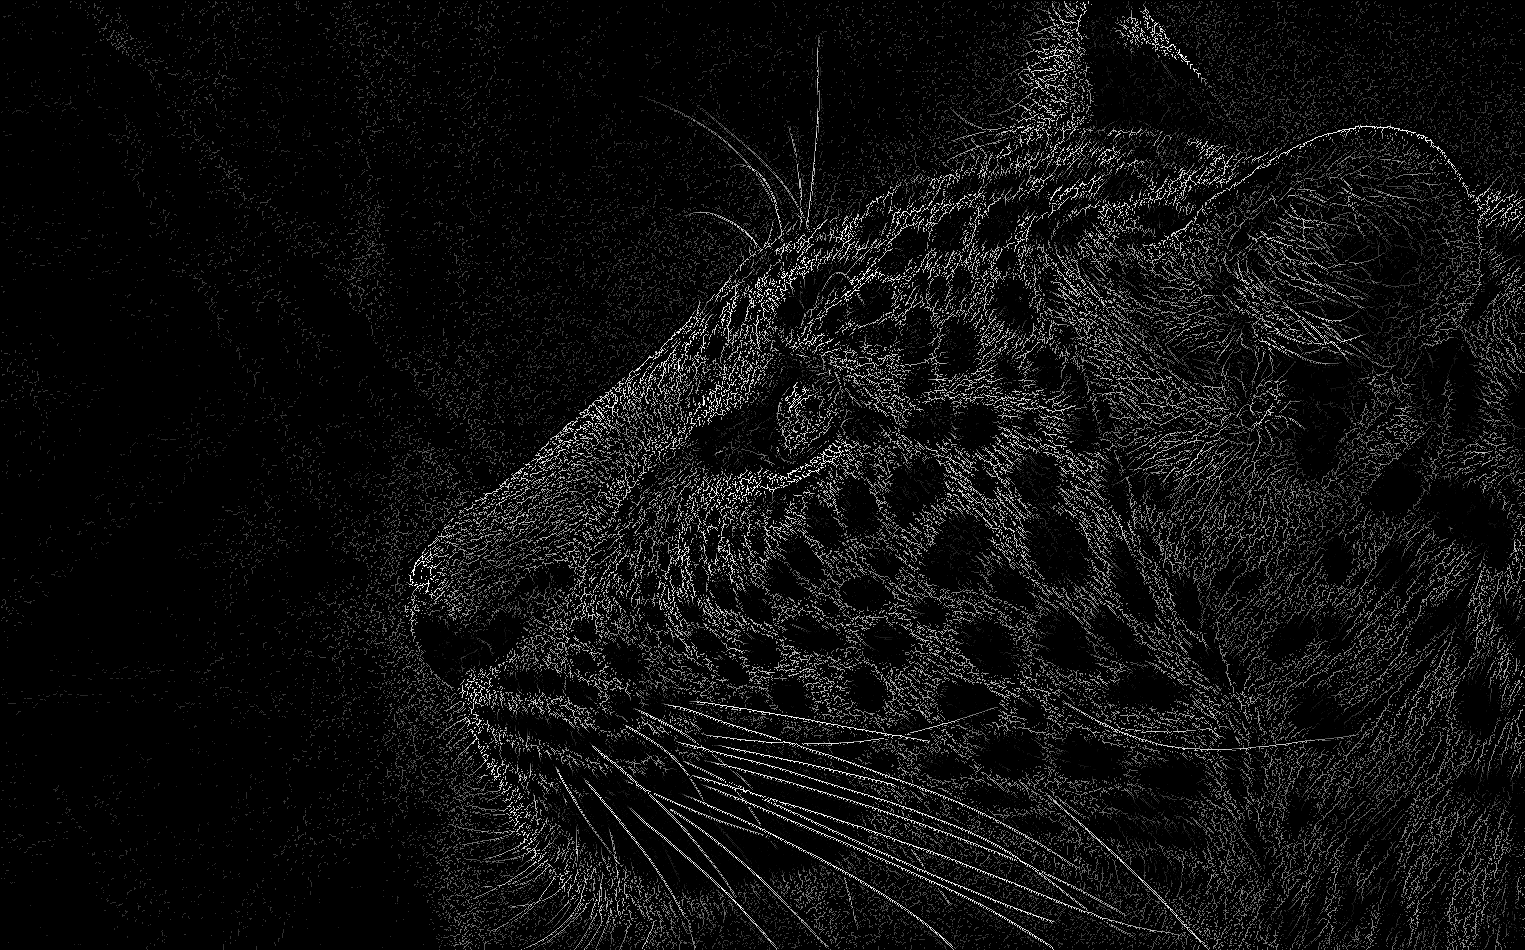

In [ ]:
# See the output
edge_img

Thanks!